In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [186]:
process_rates = {
    "Produce": {"mean": 380, "sd": 120},
    "Work": {"mean": 10, "sd": 10},
    "ToolOccupied": {"mean": 30, "sd": 30},
    "PostProcess1": {"mean": 20, "sd": 20},
    "PostProcess2": {"mean": 10, "sd": 10},
}

In [196]:
# Define the places with initial tokens
work_frequency_when_tool_available = 0
post_processing_times = []
buffer_token_counts = {'Buffer2': [], 'Buffer3': []}
tool_occupancy_times = []

places = {
    'Production': 1, 
    'Buffer1': 0,
    'Buffer2': 0,
    'Buffer3': 0,
    'WorkOnItem': 0,
    'ToolOccupied': 1,
    'ParallelPostProcessing': 0
}
transitions_with_rates = {
    'ProduceToEnd': {'in': ['Production'], 'out': ['Buffer1'], 'rate': 'Produce'},
    'Buffer1ToWork': {'in': ['Buffer1'], 'out': ['WorkOnItem'], 'rate': 'Work'},
    'WorkToToolOccupied': {'in': ['WorkOnItem'], 'out': ['ToolOccupied'], 'rate': 'ToolOccupied'},
    'ToolOccupiedToEnd': {'in': ['ToolOccupied'], 'out': ['Buffer2', 'Buffer3'], 'rate': 'ToolOccupied'},
    'Buffer2ToPostProcess': {'in': ['Buffer2'], 'out': ['ParallelPostProcessing'], 'rate': 'PostProcess1'},
    'Buffer3ToPostProcess': {'in': ['Buffer3'], 'out': ['ParallelPostProcessing'], 'rate': 'PostProcess2'}
}
def is_transition_enabled(transition):
    return all(places[place] > 0 for place in transitions_with_rates[transition]['in'])
def log_token_changes(transition, places_before, places_after):
    # Log the removal of tokens
    for place in transitions_with_rates[transition]['in']:
        if places_before[place] != places_after[place]:
            print(f"Transition {transition}: Token removed from {place}.")
    # Log the addition of tokens
    for place in transitions_with_rates[transition]['out']:
        if places_before[place] != places_after[place]:
            print(f"Transition {transition}: Token added to {place}.")

def is_tool_unavailable():
    # 10% chance the tool is unavailable
    return np.random.random() < 0.1

def reschedule(current_time):
    mu, sigma = -1, 1
    rescheduled_time = current_time + abs(int(np.random.normal(mu, sigma))) + 1
    return rescheduled_time

def fire_transition_with_time_and_log(transition, current_time):
    global work_frequency_when_tool_available
    if is_transition_enabled(transition):
        process_time = simulate_process_time(transitions_with_rates[transition]['rate'])
        places_before = places.copy()

        for place in transitions_with_rates[transition]['in']:
            places[place] -= 1
        
        if transition == 'ToolOccupiedToEnd':
            # Decide whether the token goes to Buffer 2 or Buffer 3
            if random.random() < 0.5:  # 50% chance
                places['Buffer2'] += 1  
                # print(f"Token moved to Buffer 2")
            else:
                places['Buffer3'] += 1  # Token goes to Buffer 3
                # print(f"Token moved to Buffer 3")
        else:
            for place in transitions_with_rates[transition]['out']:
                places[place] += 1
        
        places_after = places.copy()
        log_token_changes(transition, places_before, places_after)
        buffer_token_counts['Buffer2'].append(places['Buffer2'])
        buffer_token_counts['Buffer3'].append(places['Buffer3'])
        # print(f"After {transition}, Buffer 2 count: {places['Buffer2']}, Buffer 3 count: {places['Buffer3']}")

        if transition == 'WorkToToolOccupied':
            # Check for tool unavailability
            if is_tool_unavailable():
                print("Tool is unavailable, rescheduling...")
                rescheduled_time = reschedule(current_time + process_time)
                tool_occupancy_times.append(('occupied', current_time, rescheduled_time))
            else:
                tool_occupancy_times.append(('occupied', current_time, current_time + process_time))
                work_frequency_when_tool_available += 1
                print("current work fequency : ", work_frequency_when_tool_available)

        elif transition == 'ToolOccupiedToEnd':
            # Log the time the tool becomes free, which is the end of the occupation period
            tool_occupancy_times.append(('free', current_time))

        elif transition in ['Buffer2ToPostProcess', 'Buffer3ToPostProcess']:
            post_processing_times.append((current_time, current_time + process_time))
        return process_time
    return 0


def simulate_process_time(rate_name):
    mean = process_rates[rate_name]['mean']
    sd = process_rates[rate_name]['sd']
    # Simulate the process time using a normal distribution
    process_time = max(0, np.random.normal(mean, sd)) 
    return process_time




In [197]:
simulation_time = 12 * 60

production_times = []
transition_frequencies = {transition: 0 for transition in transitions_with_rates}
current_time = 0
tool_occupancy_times = []

for iteration in range(1000):  
    simulation_clock = 0  
    places['Production'] = 1  

    while simulation_clock < simulation_time and places['Production'] > 0:
        if is_transition_enabled('ProduceToEnd'):
            process_time = simulate_process_time(transitions_with_rates['ProduceToEnd']['rate'])
            simulation_clock += fire_transition_with_time_and_log('ProduceToEnd', simulation_clock)
            production_times.append(simulation_clock)
            transition_frequencies['ProduceToEnd'] += 1

        if is_transition_enabled('Buffer1ToWork'):
            process_time = simulate_process_time(transitions_with_rates['Buffer1ToWork']['rate'])
            simulation_clock += fire_transition_with_time_and_log('Buffer1ToWork', simulation_clock)
            transition_frequencies['Buffer1ToWork'] += 1

        if is_transition_enabled('WorkToToolOccupied'):
            process_time = simulate_process_time(transitions_with_rates['WorkToToolOccupied']['rate'])
            simulation_clock += fire_transition_with_time_and_log('WorkToToolOccupied', simulation_clock)

            transition_frequencies['WorkToToolOccupied'] += 1

        if is_transition_enabled('ToolOccupiedToEnd'):
            process_time = simulate_process_time(transitions_with_rates['ToolOccupiedToEnd']['rate'])
            simulation_clock += fire_transition_with_time_and_log('ToolOccupiedToEnd', simulation_clock)
            transition_frequencies['ToolOccupiedToEnd'] += 1

        if is_transition_enabled('Buffer2ToPostProcess'):
            process_time = simulate_process_time(transitions_with_rates['Buffer2ToPostProcess']['rate'])
            simulation_clock += fire_transition_with_time_and_log('Buffer2ToPostProcess', simulation_clock)
            transition_frequencies['Buffer2ToPostProcess'] += 1

        if is_transition_enabled('Buffer3ToPostProcess'):
            process_time = simulate_process_time(transitions_with_rates['Buffer3ToPostProcess']['rate'])
            simulation_clock += fire_transition_with_time_and_log('Buffer3ToPostProcess', simulation_clock)
            transition_frequencies['Buffer3ToPostProcess'] += 1
    # # Simulation loop
    # while simulation_clock < small_simulation_time:
    #     # Check and fire transitions in the order defined by the transitions_with_rates
    #     for transition in transitions_with_rates:
    #         # Pass 'places' as an argument to the is_transition_enabled function
    #         if is_transition_enabled(transition, places):
    #             # Simulate the process time for the transition and fire it
    #             process_time = simulate_process_time(transitions_with_rates[transition]['rate'])
    #             simulation_clock += fire_transition_with_time_and_log(transition, simulation_clock, places)
    #             # If it's a production event, record the time
    #             if transition == 'ProduceToEnd':
    #                 production_times.append(simulation_clock)
    #             # Update the frequency for this transition
    #             transition_frequencies[transition] += 1
    #             # Break after each transition fire to evaluate conditions from the start
    #             break

Transition ProduceToEnd: Token removed from Production.
Transition ProduceToEnd: Token added to Buffer1.
Transition Buffer1ToWork: Token removed from Buffer1.
Transition Buffer1ToWork: Token added to WorkOnItem.
Transition WorkToToolOccupied: Token removed from WorkOnItem.
Transition WorkToToolOccupied: Token added to ToolOccupied.
current work fequency :  1
Transition ToolOccupiedToEnd: Token removed from ToolOccupied.
Transition ToolOccupiedToEnd: Token added to Buffer2.
Transition Buffer2ToPostProcess: Token removed from Buffer2.
Transition Buffer2ToPostProcess: Token added to ParallelPostProcessing.
Transition ProduceToEnd: Token removed from Production.
Transition ProduceToEnd: Token added to Buffer1.
Transition Buffer1ToWork: Token removed from Buffer1.
Transition Buffer1ToWork: Token added to WorkOnItem.
Transition WorkToToolOccupied: Token removed from WorkOnItem.
Transition WorkToToolOccupied: Token added to ToolOccupied.
Tool is unavailable, rescheduling...
Transition ToolOcc

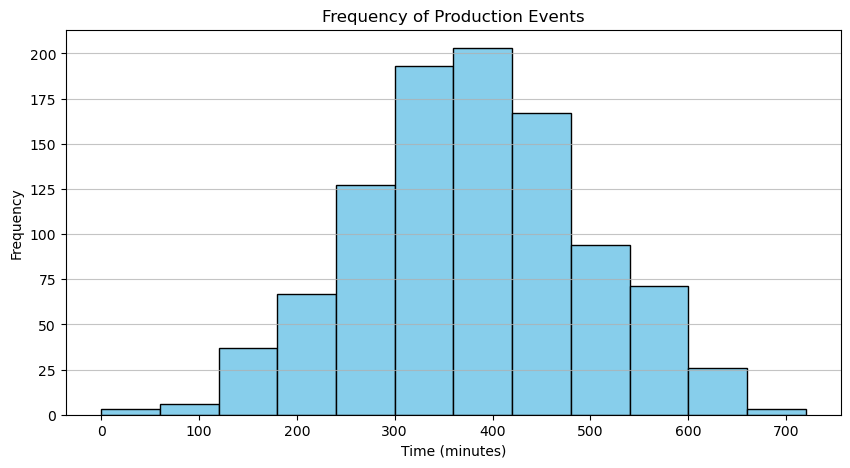

In [198]:
# Visualize the frequency of 'Production' events
plt.figure(figsize=(10, 5))
plt.hist(production_times, bins=range(0, int(simulation_time) + 1, 60), color='skyblue', edgecolor='black')
plt.title('Frequency of Production Events')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [199]:
# Calculate percentiles for Buffer 2
percentiles_buffer2 = np.percentile(buffer_token_counts['Buffer2'], [50, 75, 90, 95, 99])

# Calculate percentiles for Buffer 3
percentiles_buffer3 = np.percentile(buffer_token_counts['Buffer3'], [50, 75, 90, 95, 99])

print("Buffer 2 Capacity Estimates at Different Percentiles:", percentiles_buffer2)
print("Buffer 3 Capacity Estimates at Different Percentiles:", percentiles_buffer3)

Buffer 2 Capacity Estimates at Different Percentiles: [0. 0. 0. 1. 1.]
Buffer 3 Capacity Estimates at Different Percentiles: [0. 0. 1. 1. 1.]


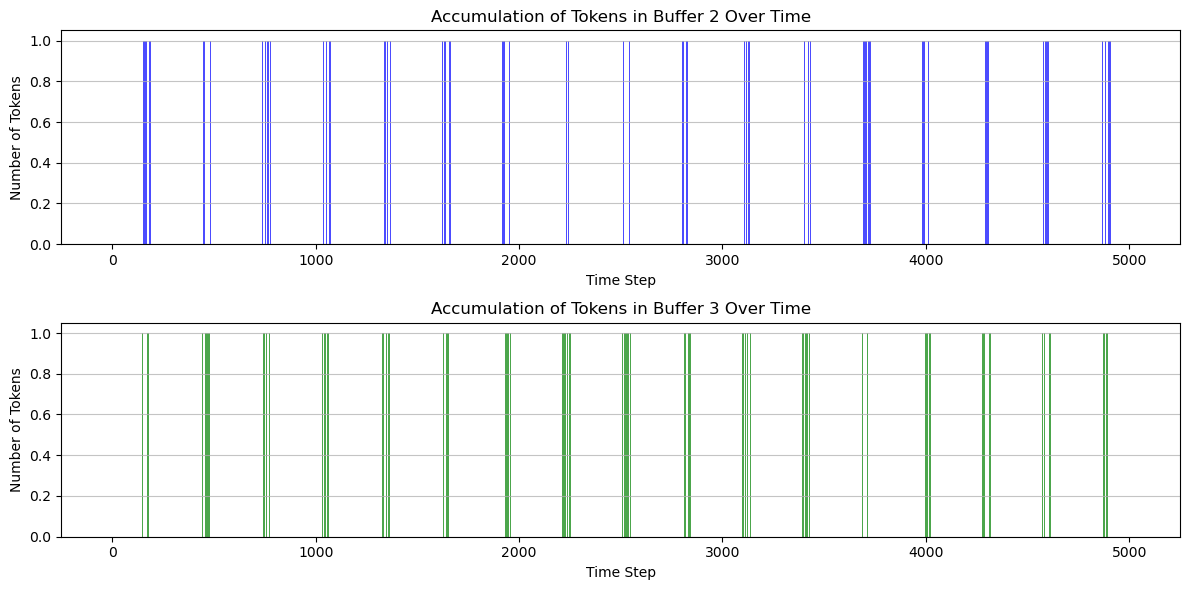

In [200]:
buffer2_counts = buffer_token_counts['Buffer2']
buffer3_counts = buffer_token_counts['Buffer3']

time_steps = list(range(len(buffer2_counts)))  # Assume each count is a separate time step

# Plotting the accumulation of tokens in Buffer 2 over time
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.bar(time_steps, buffer2_counts, color='blue', alpha=0.7)
plt.title('Accumulation of Tokens in Buffer 2 Over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Tokens')
plt.grid(axis='y', alpha=0.75)

# Plotting the accumulation of tokens in Buffer 3 over time
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.bar(time_steps, buffer3_counts, color='green', alpha=0.7)
plt.title('Accumulation of Tokens in Buffer 3 Over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Tokens')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [201]:
# Calculate durations of each post-processing event
post_processing_durations = [end - start for start, end in post_processing_times]

average_duration = sum(post_processing_durations) / len(post_processing_durations) if post_processing_durations else 0
print("Average Post-Processing Duration:", average_duration)


Average Post-Processing Duration: 15.729029625222616


In [202]:
tool_unavailable_durations = []

for i in range(0, len(tool_occupancy_times), 2):
    if i + 1 < len(tool_occupancy_times):
        occupied_event = tool_occupancy_times[i]
        free_event = tool_occupancy_times[i + 1]

        if occupied_event[0] == 'occupied' and free_event[0] == 'free':
            duration = free_event[1] - occupied_event[1]
            if duration > 0:
                tool_unavailable_durations.append(duration)

print("Tool Unavailability Durations:", sum(tool_unavailable_durations))
print("Durations:", len(tool_occupancy_times))
print("Tool Unavailability frequency: ", len(tool_unavailable_durations))

Tool Unavailability Durations: 32799.328173282935
Durations: 2000
Tool Unavailability frequency:  833


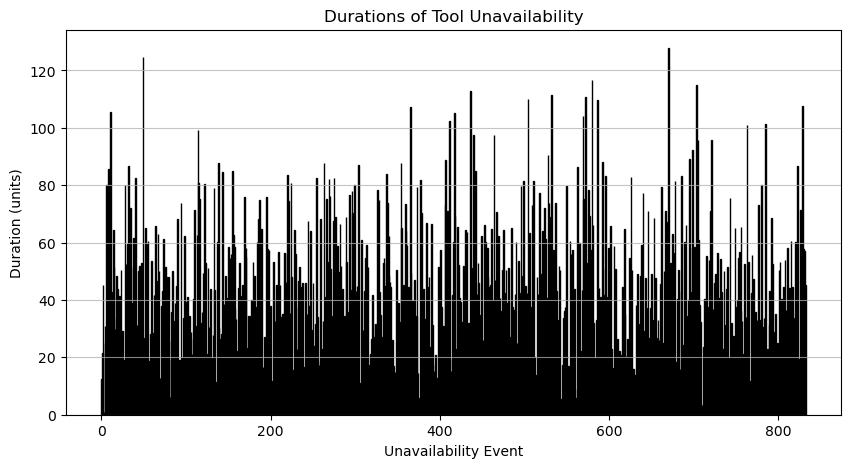

In [203]:
# Plotting the durations of tool unavailability
plt.figure(figsize=(10, 5))
plt.bar(range(len(tool_unavailable_durations)), tool_unavailable_durations, color='skyblue', edgecolor='black')
plt.title('Durations of Tool Unavailability')
plt.xlabel('Unavailability Event')
plt.ylabel('Duration (units)')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [204]:
work_frequency_when_tool_available

910